# Lab 3 A: Neural Network for Customer Churn Prediction

**Dataset:** `churn.csv`  
**Goal:** Predict whether a bank customer will leave the bank (`Exited = 1`) using a neural network classifier.

You will implement the following pieces:

1. `prepare_data(df)` – preprocessing, encoding, scaling, train/validation split  
2. `ChurnDataset` – custom PyTorch Dataset  
3. `build_model(input_dim)` – neural network classifier  
4. `train_one_epoch(model, train_loader, criterion, optimizer)` – train loop for one epoch  
5. `evaluate(model, val_loader)` – compute validation accuracy

All these will be **autograded** with nbgrader.

**Important:**  
- Do not change function names or their parameters.  
- Do not change the return types.  
- Do not remove or rename variables used in the templates.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

df = pd.read_csv("churn.csv")
df.sample()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
288,289,15727556,O'Donnell,744,Spain,Female,26,5,166297.89,1,1,1,181694.44,0


In [3]:
### AUTOGRADED TASK
def prepare_data(df: pd.DataFrame):
    """
    Prepare the churn data for a neural network.
    """

      # 1. Drop unnecessary columns
    df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

    # 2. Separate features and target
    X = df.drop(columns=["Exited"])
    y = df["Exited"].values

    # 3. ColumnTransformer with OneHotEncoder
    categorical_cols = ["Geography", "Gender"]

    try:
        encoder = OneHotEncoder(drop="first", sparse_output=False)
    except TypeError:
        # For older sklearn versions
        encoder = OneHotEncoder(drop="first", sparse=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", encoder, categorical_cols)
        ],
        remainder="passthrough"
    )

    # 4. Apply transformer
    X_transformed = preprocessor.fit_transform(X)

    # 5. Scale ALL features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_transformed)

    # 6. Train / validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    # 7. Return
    return X_train, X_val, y_train, y_val, preprocessor, scaler

    
    

In [4]:
X_train, X_val, y_train, y_val, preprocessor, scaler = prepare_data(df)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 11), (2000, 11), (8000,), (2000,))

In [7]:
### AUTOGRADED TASK
class ChurnDataset(Dataset):
    """
    A PyTorch Dataset for the churn data.

    - __init__(self, X, y):
        * X: numpy array of features
        * y: array-like of labels (0 or 1)
        * store them as tensors:
             - X as float32
             - y as float32 with shape (N, 1)
    - __len__(self): returns number of samples
    - __getitem__(self, idx): returns (X[idx], y[idx])
    """

    # YOUR CODE HERE
    def __init__(self, X, y):
        # X: numpy array -> float32 tensor
        self.X = torch.tensor(X, dtype=torch.float32)

        # y: (N,) -> (N, 1) float32 tensor
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
train_ds = ChurnDataset(X_train, y_train)
val_ds = ChurnDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)

len(train_ds), len(val_ds)

(8000, 2000)

In [9]:
### AUTOGRADED TASK
def build_model(input_dim: int) -> nn.Module:
    """
    Build and return a PyTorch neural network for binary classification.

    Requirements:
    - Use nn.Sequential
    - Architecture suggestion (you may use exactly this):
        Linear(input_dim, 32) -> ReLU
        Linear(32, 16) -> ReLU
        Linear(16, 1) -> Sigmoid
    - The final layer MUST have 1 neuron with Sigmoid activation (output in [0,1]).
    """

    # YOUR CODE HERE
    model = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid()
    )

    return model

In [10]:
input_dim = X_train.shape[1]
model = build_model(input_dim)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

Sequential(
  (0): Linear(in_features=11, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)

In [11]:
### AUTOGRADED TASK
def train_one_epoch(model: nn.Module,
                    train_loader: DataLoader,
                    criterion,
                    optimizer) -> float:
    """
    Train the model for ONE epoch on the training data.

    Requirements:
    - Set model to train mode: model.train()
    - Loop over batches from train_loader
      * Compute predictions
      * Compute loss
      * Zero the gradients
      * Backpropagate
      * Step the optimizer
      * Accumulate the loss (sum)
    - Return the average training loss as a float 
      (total loss divided by number of batches)
    """

    # YOUR CODE HERE
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Average loss
    avg_loss = total_loss / len(train_loader)

    return avg_loss

In [12]:
### AUTOGRADED TASK
def evaluate(model: nn.Module, val_loader: DataLoader) -> float:
    """
    Evaluate the model on the validation data.

    Requirements:
    - Set the model to eval mode: model.eval()
    - Disable gradients using torch.no_grad()
    - Loop over batches from val_loader:
        * Compute predictions
        * Convert predictions to labels using threshold 0.5
        * Collect all true labels and predicted labels
    - Return the accuracy on the full validation set as a float in [0, 1].
    """

    # YOUR CODE HERE
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)

            # Convert probabilities to binary predictions
            preds = (outputs >= 0.5).float()

            all_preds.append(preds)
            all_labels.append(y_batch)

    # Concatenate all batches
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    accuracy = accuracy_score(all_labels, all_preds)

    return accuracy

In [13]:
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = evaluate(model, val_loader)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Val acc: {val_acc:.4f}")

Epoch 1/10 | Train loss: 0.5433 | Val acc: 0.7970
Epoch 2/10 | Train loss: 0.4360 | Val acc: 0.8175
Epoch 3/10 | Train loss: 0.4207 | Val acc: 0.8255
Epoch 4/10 | Train loss: 0.4113 | Val acc: 0.8350
Epoch 5/10 | Train loss: 0.4023 | Val acc: 0.8390
Epoch 6/10 | Train loss: 0.3940 | Val acc: 0.8405
Epoch 7/10 | Train loss: 0.3847 | Val acc: 0.8490
Epoch 8/10 | Train loss: 0.3742 | Val acc: 0.8480
Epoch 9/10 | Train loss: 0.3631 | Val acc: 0.8515
Epoch 10/10 | Train loss: 0.3552 | Val acc: 0.8575


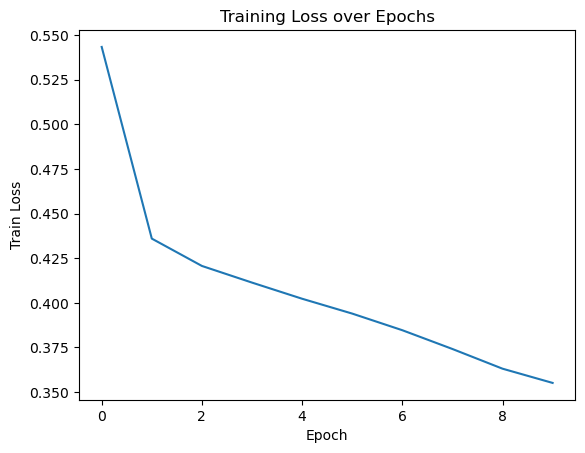

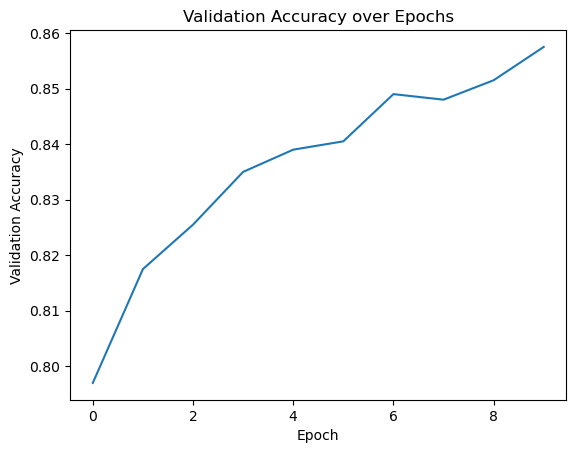

In [14]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss over Epochs")
plt.show()

plt.plot(val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.show()

## Answer

1. What validation accuracy did you reach ? 0.85 
2. Does the model appear to overfit or underfit?
3. Name one way to potentially improve performance (architecture or preprocessing).


## Run the tests to verify your solution

In [17]:
import hashlib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

def hash_data_frame(df: pd.DataFrame) -> str:
    """
    Compute a stable hash for a DataFrame by:
    - sorting columns
    - sorting rows by all columns
    - hashing the underlying values
    """
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

def hash_series(series: pd.Series) -> str:
    """
    Compute a stable hash for a Series by:
    - converting values to string
    - joining with commas
    - hashing the resulting string
    """
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

def check_signature(expected: str, actual: str):
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

def test_prepare_data(func, sig_X_train, sig_X_val, sig_y_train, sig_y_val):
    """
    Wrapper for testing the student's `prepare_data(df)` function using hashes.
    """
    df = pd.read_csv("churn.csv")
    X_train, X_val, y_train, y_val, preprocessor, scaler = func(df)

    # Convert to DataFrame / Series for hashing
    X_train_df = pd.DataFrame(X_train)
    X_val_df = pd.DataFrame(X_val)
    y_train_s = pd.Series(y_train).reset_index(drop=True)
    y_val_s = pd.Series(y_val).reset_index(drop=True)

    # Basic sanity
    assert X_train_df.shape[0] > 0
    assert X_val_df.shape[0] > 0
    assert X_train_df.shape[1] == X_val_df.shape[1]

    # Hashes
    h_Xtr = hash_data_frame(X_train_df)
    h_Xv  = hash_data_frame(X_val_df)
    h_ytr = hash_series(y_train_s)
    h_yv  = hash_series(y_val_s)

    try:
        assert h_Xtr == sig_X_train
        assert h_Xv  == sig_X_val
        assert h_ytr == sig_y_train
        assert h_yv  == sig_y_val
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed (signatures do not match).")
        # Uncomment while generating signatures:
        # print("DEBUG:", h_Xtr, h_Xv, h_ytr, h_yv)
        raise

In [18]:
### TEST
SIG_X_TRAIN = "5c50238ec85cb41c11b0eabc4be851c56a41aa367bc3945dcfc07e83a5e8e079"
SIG_X_VAL   = "4ef850e8dea3a9f462535f178165dc02b06a1f5e31ac9d364d779b291407d33a"
SIG_Y_TRAIN = "9b8c6fff66645ef6ca27fb516a51c4c9d2645710f2809c05887d98fa938e93e4"
SIG_Y_VAL   = "516080ad1fc8e2349df09a1de08ffb3fc50d7ff7a36c5f4f82af08b8ef55f783"

test_prepare_data(
    prepare_data,
    SIG_X_TRAIN,
    SIG_X_VAL,
    SIG_Y_TRAIN,
    SIG_Y_VAL
)


✔ Test passed!


In [19]:
### TEST 
train_ds = ChurnDataset(X_train, y_train)

# basic length
assert len(train_ds) == X_train.shape[0]

# sample item
x0, y0 = train_ds[0]
assert isinstance(x0, torch.Tensor)
assert isinstance(y0, torch.Tensor)
assert x0.shape[0] == X_train.shape[1]
assert y0.shape == (1,)
assert x0.dtype == torch.float32
assert y0.dtype == torch.float32

print("✔ Test passed!")


✔ Test passed!


In [20]:
### TEST 
input_dim = X_train.shape[1]
model_test = build_model(input_dim)

assert isinstance(model_test, torch.nn.Module)

dummy = torch.randn(4, input_dim)
out = model_test(dummy)

# output shape and range
assert out.shape == (4, 1)
assert torch.all(out >= 0.0)
assert torch.all(out <= 1.0)

print("✔ Test passed!")


✔ Test passed!


In [21]:
### TEST 
train_loader_test = DataLoader(ChurnDataset(X_train, y_train), batch_size=64, shuffle=True)

model_te = build_model(X_train.shape[1])
criterion_te = torch.nn.BCELoss()
optimizer_te = torch.optim.Adam(model_te.parameters(), lr=0.001)

loss1 = train_one_epoch(model_te, train_loader_test, criterion_te, optimizer_te)

assert isinstance(loss1, float)
assert 0.0 < loss1 < 10.0   # loose bounds

print("✔ Test passed!")


✔ Test passed!


In [22]:
### TEST 
val_loader_test = DataLoader(ChurnDataset(X_val, y_val), batch_size=256, shuffle=False)

acc_val = evaluate(model_te, val_loader_test)

assert isinstance(acc_val, float)
assert 0.0 <= acc_val <= 1.0

print("✔ Test passed!")


✔ Test passed!
